#Introducing key concepts: Under- & Overfitting & Feature Importance
January 2024
* Johanna Norell
* Andreas Helgesson
* Axel Blom


# Extracting the data


In [ ]:
# Run necessary imports for this step
from google.colab import files
import pandas as pd

In [ ]:
# Upload the CSV files to Colab
uploaded = files.upload()

Saving adult_test.csv to adult_test.csv
Saving adult_train.csv to adult_train.csv


In [ ]:
# Read the CSV files
data_test = pd.read_csv('adult_test.csv')
data_train = pd.read_csv('adult_train.csv')

In [ ]:
# Split the data into input X and output Y
X_train = data_train.drop('target', axis=1)  # Drop the target column from the input
Y_train = data_train[['target']]  # Take only the target column as the output

X_test = data_test.drop('target', axis=1)  # Drop the target column from the input
Y_test = data_test[['target']]  # Take only the target column as the output

#Establishing baseline classifier

In [ ]:
# Run necessary imports for this step
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import numpy as np

In [ ]:
# Convert dataframes to dictionaries
X_train_dict = X_train.to_dict('records')

X_test_dict = X_test.to_dict('records')

In [ ]:
# Initialize DictVectorizer
dv = DictVectorizer(sparse=False)

# Fit and transform on the training data
X_train_transformed = dv.fit_transform(X_train_dict)

In [ ]:
# Calculate the mean cross-validation accuracy on the training set, here using a DecisionTreeClassifier
clf = DecisionTreeClassifier()
accuracy = np.mean(cross_val_score(clf, X_train_transformed, Y_train))
print(accuracy)

0.8183409970835122


Cross-validation accuracy achieved on the training set is 81.8%. We now train in the entire training set and check the accuracy on the test set:

In [ ]:
# Fit model
clf.fit(X_train_transformed, Y_train)

# Transform the test data using the same vectorizer
X_test_encoded = dv.transform(X_test_dict)

# Evaluate on the test set
predictions = clf.predict(X_test_encoded)
accuracy = accuracy_score(Y_test, predictions)
print("Accuracy: " + str(accuracy))

Accuracy: 0.8164731896075179


#Creating pipeline

In [ ]:
# Run necessary imports for this step
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier

In [ ]:
# Create a pipeline with DictVectorizer and DecisionTreeClassifier
pipeline = make_pipeline(
    DictVectorizer(sparse=False),
    DecisionTreeClassifier()
)

# Fit the pipeline on the training data
pipeline.fit(X_train_dict, Y_train)

Pipeline(steps=[('dictvectorizer', DictVectorizer(sparse=False)),
                ('decisiontreeclassifier', DecisionTreeClassifier())])

In [ ]:
# Predict on the test data using the pipeline
predictions = pipeline.predict(X_test_dict)

accuracy = accuracy_score(Y_test, predictions)
print("Accuracy: " + str(accuracy))

Accuracy: 0.8164117683188993


# Evaluating under- and overfitting

### Underfitting and overfitting in decision tree classifiers.

In [ ]:
# Run necessary imports for this step
import matplotlib.pyplot as plt

In [ ]:
train_scores = []
test_scores = []

# For each maximum depth value, train a model and evaluate on the training and testing data
for i in range(1, 40):
  # Create a pipieline and fit
  pipeline = make_pipeline(
    DictVectorizer(sparse=False),
    DecisionTreeClassifier(max_depth=i)
  )
  pipeline.fit(X_train_dict, Y_train)

  # Evaluate and save scores
  Yguess_train = pipeline.predict(X_train_dict) # Predict on training data
  Yguess_test = pipeline.predict(X_test_dict) # Predict on testing data
  train_scores.append(accuracy_score(Y_train, Yguess_train)) # Save scores
  test_scores.append(accuracy_score(Y_test, Yguess_test)) # Save scores

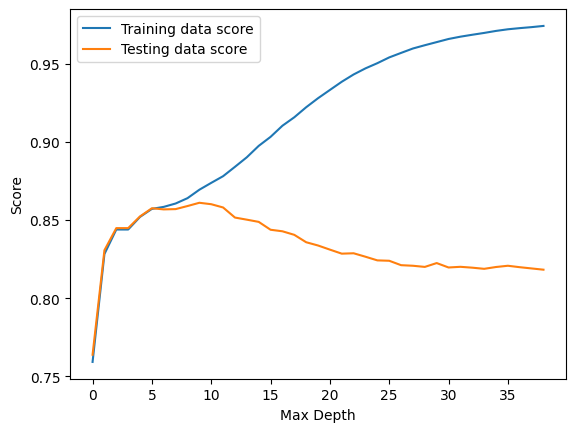

In [ ]:
# Visualize results
plt.plot(train_scores, label='Training data score')
plt.plot(test_scores, label='Testing data score')
plt.xlabel('Max Depth')
plt.ylabel('Score')
plt.legend()
plt.show()

*Do you see a similar effect now?*

Yes, we do see an effect similar to that in the percious assignment. We see that accuracy for training data approaches 1 as the max depth increases, as expected, and we see that accuracy for testing data initially increases, reaches a maximum, and then starts to decrease again due to overfitting.

However, we should note that the testing data accuracy curve in the last assignment seemed to be more parabolic in nature, appearing almost symmetrical around the optimal value. In this case, the testing data accuracy curve appears to plateau after a quick initial increase. It does start to descend, but not symmetricaly as in the previous assignment.

### Underfitting and overfitting in random forest classifiers.

In [ ]:
# Run necessary imports for this step
from sklearn.ensemble import RandomForestClassifier
import time # Used to time code execution

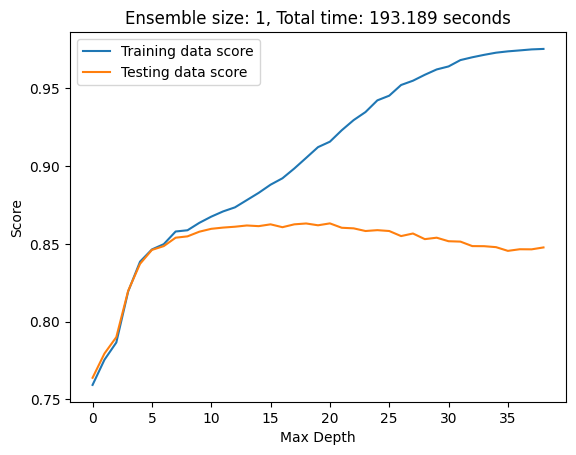

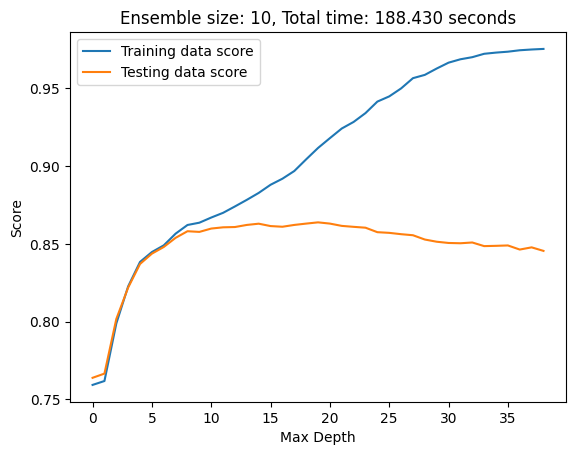

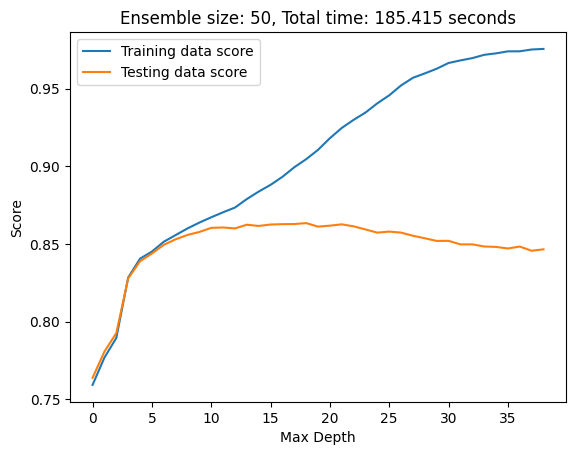

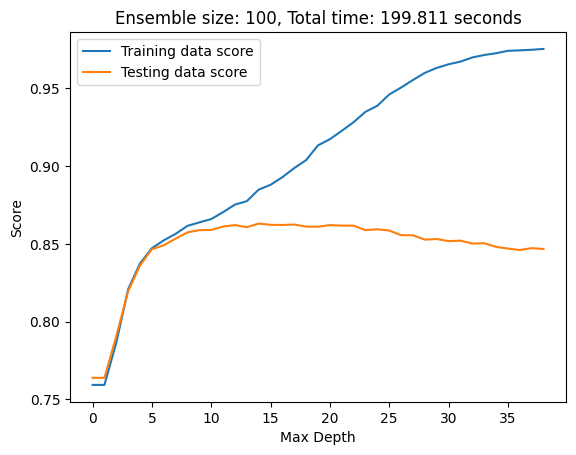

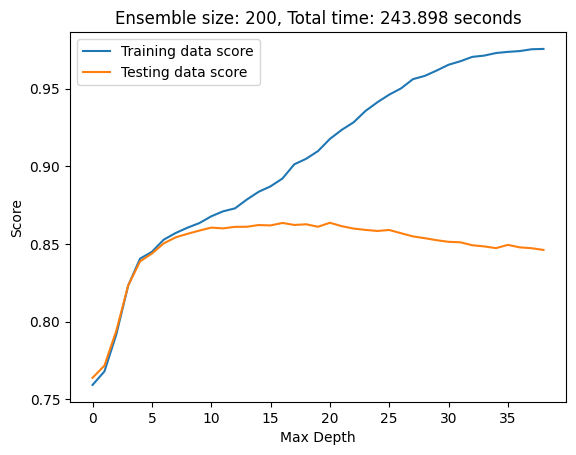

In [ ]:
# Define ensemble sized to use
n_estimators = [1, 10, 50, 100, 200]

# Flatten Y_train to 1D-array
Y_train_flattened = np.ravel(Y_train)

for n in n_estimators:

  train_scores = []
  test_scores = []

  tic = time.perf_counter() # Start time

  # Calculate scores for each tree depth
  for i in range(1, 40):
    pipeline = make_pipeline(
      DictVectorizer(sparse=False),
      RandomForestClassifier(max_depth=i, n_jobs=-1)
    )
    pipeline.fit(X_train_dict, Y_train_flattened)
    Yguess_train = pipeline.predict(X_train_dict) # Predict on training data
    Yguess_test = pipeline.predict(X_test_dict) # Predict on testing data
    train_scores.append(accuracy_score(Y_train, Yguess_train)) # Save scores
    test_scores.append(accuracy_score(Y_test, Yguess_test)) # Save scores

  toc = time.perf_counter() # End time

  # Visualize to find maximum
  plt.plot(train_scores, label='Training data score')
  plt.plot(test_scores, label='Testing data score')
  plt.xlabel('Max Depth')
  plt.ylabel('Score')
  plt.title(f'Ensemble size: {n}, Total time: {toc-tic:0.3f} seconds')
  plt.legend()
  plt.show()


*What's the difference between the curve for a decision tree and for a random forest with an ensemble size of 1, and why do we see this difference?*

Testing data accuracy for random forest seem to plateau even more than decision tree. There is not a clear max point and then a decrease, but rather a levelling out. We also see a greater gap between the training- and test data in the case of the decision tree classifier in comparison to the random forest, which highlights the fact that random forest in general are less pronounced to overfitting, due to random feature selection.

*What happens with the curve for random forests as the ensemble size grows?*

When the ensemble size grows, the performance of the random forest model is significantly stabilized. We can see that it in general has a higher accuracy score, and that the positive feature of averaging becomes more prominent. Althought, the possitive effect seem to come to a halt, and the difference between different larger ensable sizes are very smal. Considering that the 200 ensable size start to also increase in computational time, the large size is not necesarry for this model and does not equal added performance.

*What happens with the best observed test set accuracy as the ensemble size grows?*

The best observed test set accuracy becomes slightly higher as the ensemble size grows, though the difference between ensemble size 5 and 200 is not very big, but settles aroung 85%. This can be explained by the fact that the effect of averaging is more or less saturated beyond a certain size of the ensemble. In our case, we can conclude that a ensemble size of more than 5 is big enough to have a good performance.

*What happens with the training time as the ensemble size grows?*

Se visualize the training times in a plot to get a better idea of the relation betwwen training time and ensemble size:

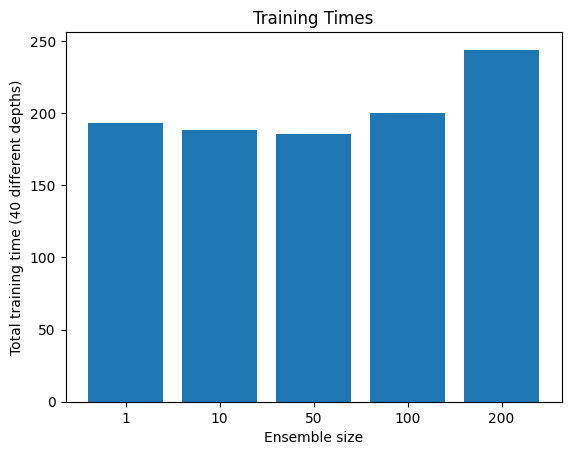

In [ ]:
# Visualize training times
plt.bar(['1','10','50','100','200'], [193.189,188.430,185.415,199.811,243.898])
plt.xlabel('Ensemble size')
plt.ylabel("Total training time (40 different depths)")
plt.title("Training Time")
plt.show()

We note that the total training time is not proportional to the ensemble sizes. There is an increase in training times as the ensemble size grows, but a duplication in ensemble size does not result in a duplication in training time. The training time is quite stable up until 100 trees. This is due to the arguemnt n_jobs=-1, letting the random forest train on multiple trees at a time. At ensamble size 200 it is not able to keep up, and the training time starts to increase. The long training times overall, comes from the max deepth being tested at quite large numbers aswell.

# Investigating feature importance

We first format and visualize the data before any discussions:

In [ ]:
# Store the feature names and importance values in a dataframe for easy access
# Note that we are using the latest pipeline used, which will be the one with a RandomForestClassifier with 200 trees and a depth of 20
data = {'features': pipeline.steps[0][1].feature_names_, 'importance':pipeline.steps[1][1].feature_importances_}
importance_scores = pd.DataFrame(data=data)
importance_scores.head() # Visualize to confirm it looks correct

,features,importance
0,age,0.104778
1,capital-gain,0.138822
2,capital-loss,0.039889
3,education-num,0.092562
4,education=10th,0.001780


In [ ]:
# Sort by importance (descending)
importance_scores.sort_values(by=['importance'], ascending=False, inplace=True)
importance_scores.head() # Visualize to confirm it looks correct

,features,importance
1,capital-gain,0.138822
23,marital-status=Married-civ-spouse,0.110525
0,age,0.104778
3,education-num,0.092562
20,hours-per-week,0.071359


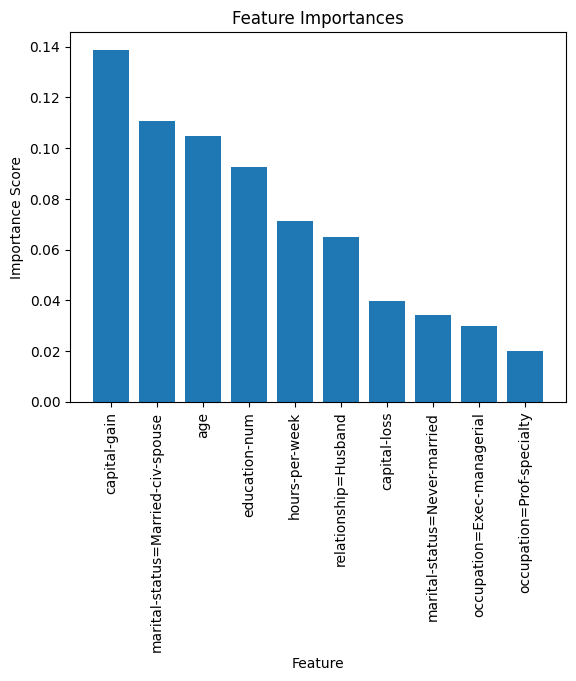

In [ ]:
# Visualize feature importances
# We opt to only show top 10 features
plt.bar(importance_scores['features'].head(10) , importance_scores['importance'].head(10))
plt.xticks(rotation='vertical')
plt.xlabel('Feature')
plt.ylabel("Importance Score")
plt.title("Feature Importances")
plt.show()

*Inspect the first few of these features, and try to reason about why you got this result.*

We clearly see that capital-gain is the best indicator feature as to whether a person is a high earner or not. Though it is not clear from this visualization, some common sense tells us that a person that receives high capital gains probably has a high salary (in order to receive high capital gains, one must hold/sell a lot of financial assets, which require a lot of money to purchase in the first place).

Such a correlation is not always immediately obvious, however. The second best feature is, according to this data, wether or not a person is married/civil union/spouse or not. It is not necessarly intuitively clear why a married person should have a higher or lower salary than one who is not, so we might want to obtain more information about the dataset to make sure that this is correct. Given that the data in this dataset is from the US in 1994 (https://archive.ics.uci.edu/dataset/2/adult), we might expect that a lot of married people are homemakers, and thus have low or no salaries, whilst those that are not married are more likely to be employed at all and thus more likely to have a high salary. To discern wether this is the case, we would need more information.

On the contrary, the third, fourth, and fifth best indicator feature are intuitively very easy to understand, as peoples age/experience, education level and work hours intuitviely have strong correlations to their salary.

When observing the features used to construct decision trees and random forest classifiers, it therefore is crucial to maintain a critical perspective and analyze whether they demonstrate correlation or causality, as exemplified above with variables such as civil status and salary level. This consideration becomes particularly significant when training the model with a relatively small dataset compared to the volume of data it will eventually classify. If we incorporate features that exhibit only correlation without causation, the accuracy of the model may significantly diminish, leading to inaccuracies when applied to real-world data.

*Alternative approach*

For an alternative way to calculate some sort of importance score for each feature, we might consider each respective features ability to predict the target value. For example, consider the following pseudo-code algorithm:

```
X = [...]
Y = [...]

importance_scores = {}

split data into training/testing

for each feature in X:
  fit model using only current feature from training data
  evalulate model accuracy using only current feature from testing data
  save current feature name and accuracy to importance_scores
```

The resulting dictionary `importance_scores` contains the accuracy a model trained on only the specified feature managed to achieve. This approach works well in theory, although it may prove computationally expensive if the dataset is large. On the the other hand, because we have a one dimensional input and one dimensional output, each model trained and evaluated is not very complex.

This approach would furthermore note take any symbiotic effects between features into account. Because only one feature at a time is evaluated, any two features that depend on each other may be misrepresented.

In any case, this approach does give a clear and easily understandable scoring of each features importance/ability for predicting the target.

If we want a more documented approach, two suitable alternative methods are **Permutation importance** and **Drop-column importance**.

Permutation importance rates the importance based on the decrease in a model's performance when the values of each feature are randomly shuffled. This process disrupts the relationship between the feature and the target highlighting how much the model's accuracy depends on the feature.

On the other hand, Drop-column importance is computed through the removal of each feature one at a time from the model, and then retraining the model and measuring the change in performance. This method directly assesses the impact of a feature on the model's predictive ability by observing how its absence affects the model's accuracy.
